# Government of Canada (GC) employment by department

Public service employment source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html

Canada population estimates source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901

In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns

# Read CSVs from ./data directory to individual DataFrames
dfs = dict()
for filename in os.listdir('./data'):
    if filename.endswith('.csv'):
        dfs[filename[:-8]] = pd.read_csv('./data/' + filename)

dfs.keys()

dict_keys(['dept-ol-lg-1', 'dept-ex-cs', 'dept-aa-am', 'dept', 'dept-province', 'dept-gen-sex-1', 'dept-t-de', 'canada-population-esim', 'dept-ab-ga-1'])

In [3]:
# Load Canada population data
pop_df = pd.read_csv('./data/canada-population-esimates.csv')
pop_df = pop_df.T.reset_index()
# pop_df
pop_df.columns = ["Year", "Population"]
# Remove rows where Year doesn't start with "Q4"
pop_df = pop_df[pop_df['Year'].str.startswith('Q4')]
# Remove "Q4 " from Year column so it is just the year
pop_df['Year'] = pop_df['Year'].str.replace('Q4 ', '')
# Convert Year column to int
pop_df['Year'] = pop_df['Year'].astype(int)
# Convert Population column to int
pop_df['Population'] = pop_df['Population'].str.replace(",", "").astype(int)
pop_df.head()

Year  Population
0   2010    34132531
4   2011    34457713
8   2012    34834973
12  2013    35209597
16  2014    35555305

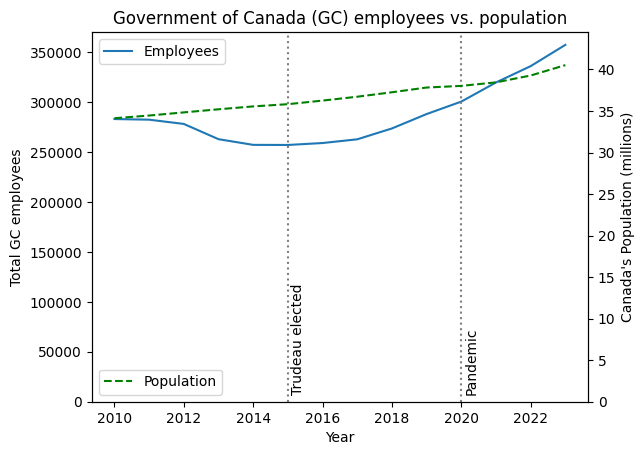

In [4]:
from matplotlib import pyplot as plt
dfs['dept'].drop(columns=['Universe']).groupby(['Year']).sum().plot(ylim=(0, 370000)).title.set_text('Government of Canada (GC) employees vs. population')
# Draw a vertical line at 2015 for Trudeau's election
plt.axvline(x=2015, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2015.1, 10000, 'Trudeau elected', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 10000, 'Pandemic', rotation=90)
# Set y-label to "Total employees"
plt.ylabel('Total GC employees')

# Add the population of Canada to the plot with a separate axis on the right
ax2 = plt.twinx()

# Plot the population of Canada
ax2.plot(pop_df['Year'], pop_df['Population'] / 1000000, color='green', linestyle='--')
# Set the y-axis limits
ax2.set_ylim(0, 44.5)
# Set the y-axis label
ax2.set_ylabel('Canada\'s Population (millions)')
# Add "Canada Population" to the legend
ax2.legend(["Population"], loc='lower left')


In [5]:
# Normalize employees column to the year's population
# Year 2010 should be 1.0 because it is the base year
dfs['dept_pop_norm'] = dfs['dept'].copy()
dfs['dept_pop_norm'] = dfs['dept_pop_norm'].merge(pop_df, on='Year')
dfs['dept_pop_norm']['Employees'] = dfs['dept_pop_norm']['Employees'] / dfs['dept_pop_norm']['Population']
dfs['dept_pop_norm']['Employees'] *= pop_df.query('Year == 2010')['Population'].values[0]
dfs['dept_pop_norm'] = dfs['dept_pop_norm'].drop(columns=['Population'])
dfs['dept_pop_norm'].head()

Year Universe                        Departments and Agencies  Employees
0  2010      CPA                Agriculture and Agri-Food Canada     6938.0
1  2010      CPA              Assisted Human Reproduction Canada       14.0
2  2010      CPA            Atlantic Canada Opportunities Agency      766.0
3  2010      CPA                   Canada Border Services Agency    14398.0
4  2010      CPA  Canada Economic Development for Quebec Regions      453.0

Text(0, 0.5, 'Total GC employees')

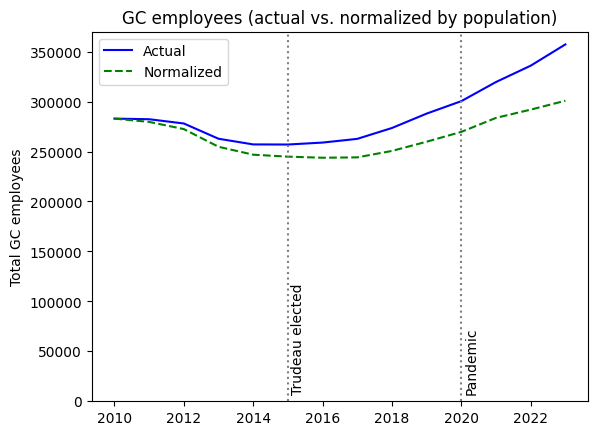

In [6]:
normalized = dfs['dept_pop_norm'].drop(columns=['Universe']).groupby(['Year']).sum()
without_norm = dfs['dept'].drop(columns=['Universe']).groupby(['Year']).sum()
# Plot both lines on the same graph
# without_norm.plot(ylim=(0, 370000)).title.set_text('GC employees (actual vs. normalized by population)')
plt.plot(without_norm["Employees"], color='blue')
plt.plot(normalized["Employees"], color='green', linestyle='--')

# Set y limits to 0, 370000
plt.ylim(0, 370000)
# Set title to "GC employees (actual vs. normalized by population)"
plt.title('GC employees (actual vs. normalized by population)')
# Add legend
plt.legend(["Actual", "Normalized"], loc='upper left')

# Draw a vertical line at 2015 for Trudeau's election
plt.axvline(x=2015, color='gray', linestyle='dotted')
# Label the vertical line
plt.text(2015.1, 10000, 'Trudeau elected', rotation=90)
# Same for pandemic in 2020
plt.axvline(x=2020, color='gray', linestyle='dotted')
plt.text(2020.1, 10000, 'Pandemic', rotation=90)
# Set y-label to "Total employees"
plt.ylabel('Total GC employees')

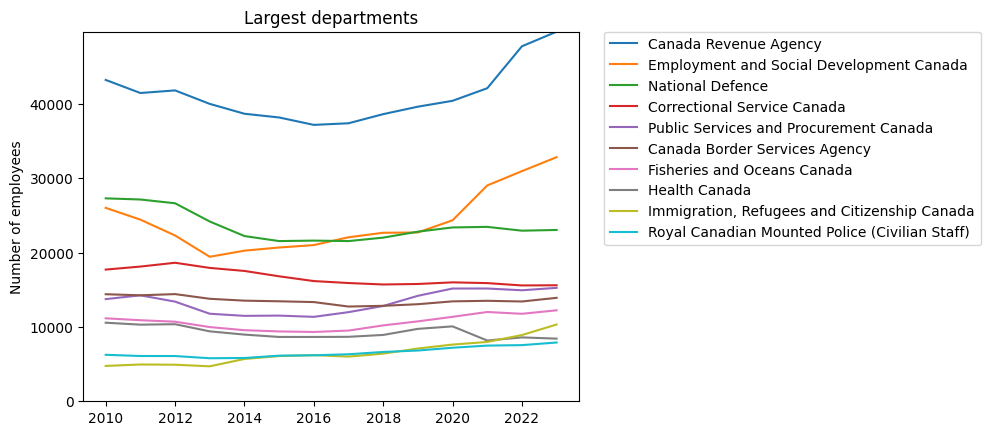

In [7]:
# Plot each department as a separate line with matplotlib
import matplotlib.pyplot as plt

df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

max_y = df["Employees"].max()
min_y = 0

top_depts = df.groupby(['Departments and Agencies']).max().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

for dept in top_depts:
    dept_size_by_year = df[df['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(min_y, max_y)
plt.ylabel('Number of employees')
plt.title('Largest departments')
plt.show()

Text(0.5, 1.0, 'Highest growth departments by absolute numbers')

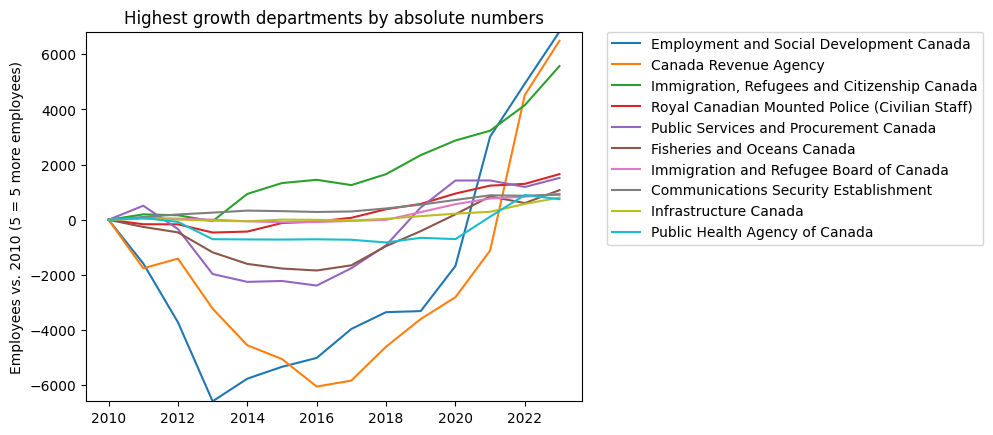

In [8]:
# Same thing but with the top 10 departments by growth in absolute numbers
df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

for dept in top_depts:
    dept_size_by_year = df_scaled[df_scaled['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(min_y, max_y)
plt.ylabel('Employees vs. 2010 (5 = 5 more employees)')
plt.title('Highest growth departments by absolute numbers')

Text(0.5, 1.0, 'Lowest growth departments by absolute numbers')

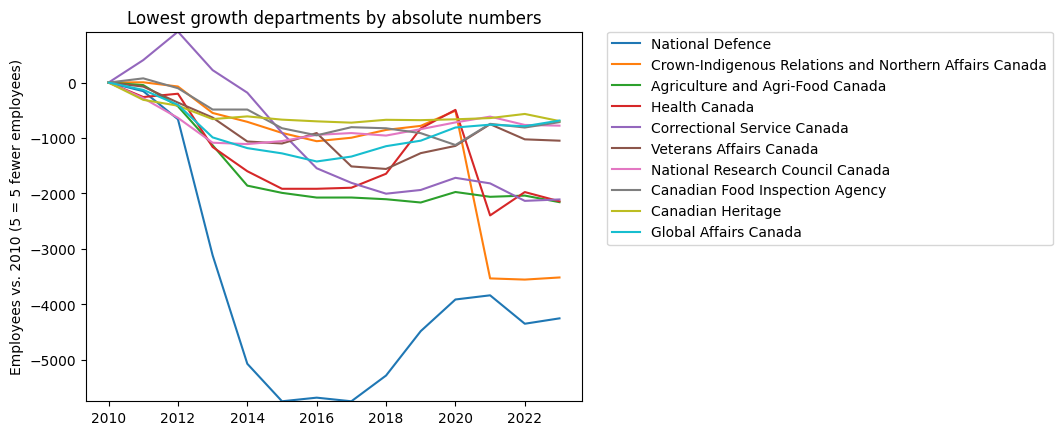

In [9]:
# Same thing but lowest growth departments by absolute numbers (i.e. shrinking)
df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=True).head(10).index.tolist()

df_scaled = df_scaled[df_scaled['Departments and Agencies'].isin(top_depts)]

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

for dept in top_depts:
    dept_size_by_year = df_scaled[df_scaled['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(min_y, max_y)
plt.ylabel('Employees vs. 2010 (5 = 5 fewer employees)')
plt.title('Lowest growth departments by absolute numbers')


Text(0.5, 1.0, 'Highest growth departments by % (any size)')

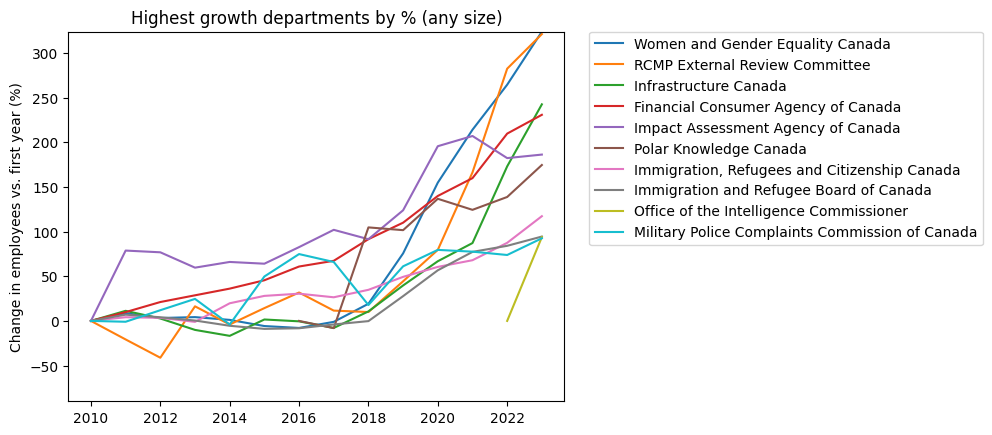

In [10]:
df = dfs["dept_pop_norm"]
df.replace(0, np.nan, inplace=True)
df = df.drop(columns=['Universe'])

# For each department, find the first year that it had more than 0 employees - and keep only that row.
# This is the first year that the department existed in the data.

df_first_year = df.dropna().sort_values(['Year']).groupby(['Departments and Agencies']).first().reset_index()
df_first_year

# For each department, normalize the number of employees to 100% in the first year that it had more than 0 employees.
# This is the ratio of employees in each year to the number of employees in the first year that the department existed.

df_growth = df.merge(df_first_year, on='Departments and Agencies', how='left', suffixes=('', '_first'))
df_growth["Employees"] = 100 * df_growth["Employees"] / df_growth["Employees_first"] - 100
df_growth = df_growth.drop(columns=['Employees_first', 'Year_first'])

# Plot the top 10 departments by growth in proportional numbers
max_y = df_growth["Employees"].max()
min_y = df_growth["Employees"].min()

top_depts = df_growth.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

df_growth = df_growth[df_growth['Departments and Agencies'].isin(top_depts)]

for dept in top_depts:
    dept_size_by_year = df_growth[df_growth['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(min_y, max_y)
plt.ylabel('Change in employees vs. first year (%)')
plt.title('Highest growth departments by % (any size)')


Text(0.5, 1.0, 'Highest growth large (> 2000 employee) departments by %')

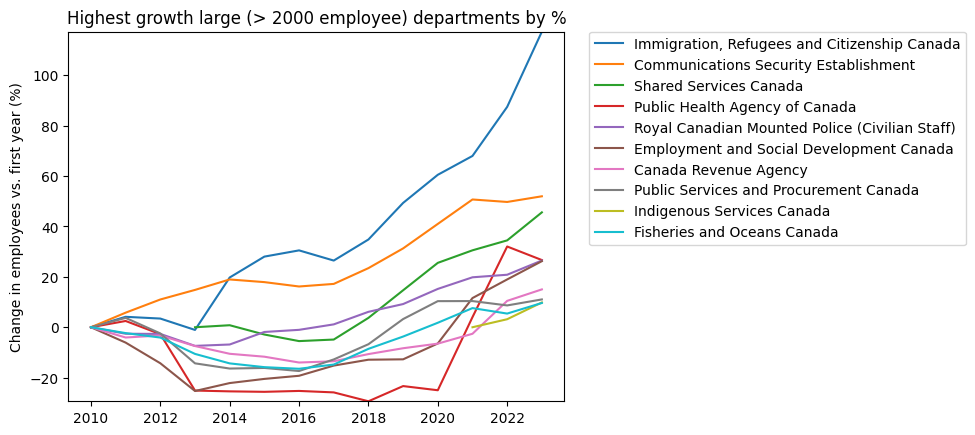

In [11]:
df = dfs["dept_pop_norm"]
df.replace(0, np.nan, inplace=True)
df = df.drop(columns=['Universe'])

# For each department, find the first year that it had more than 0 employees - and keep only that row.
# This is the first year that the department existed in the data.

df_first_year = df.dropna().sort_values(['Year']).groupby(['Departments and Agencies']).first().reset_index()
df_first_year

# For each department, normalize the number of employees to 100% in the first year that it had more than 0 employees.
# This is the ratio of employees in each year to the number of employees in the first year that the department existed.

df_growth = df.merge(df_first_year, on='Departments and Agencies', how='left', suffixes=('', '_first'))

# Filter to only departments which had more than 2000 employees in any year
large_depts = df_growth.groupby(['Departments and Agencies']).max().sort_values(by=['Employees'], ascending=False).query("Employees > 2000").index.tolist()
df_growth = df_growth[df_growth['Departments and Agencies'].isin(large_depts)]

df_growth["Employees"] = 100 * df_growth["Employees"] / df_growth["Employees_first"] - 100
df_growth = df_growth.drop(columns=['Employees_first', 'Year_first'])

top_depts = df_growth.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

df_growth = df_growth[df_growth['Departments and Agencies'].isin(top_depts)]
# Plot the top 10 departments by growth in proportional numbers
max_y = df_growth["Employees"].max()
min_y = df_growth["Employees"].min()

for dept in top_depts:
    dept_size_by_year = df_growth[df_growth['Departments and Agencies'] == dept]
    plt.plot(dept_size_by_year['Year'], dept_size_by_year['Employees'], label=dept)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(min_y, max_y)
plt.ylabel('Change in employees vs. first year (%)')
plt.title('Highest growth large (> 2000 employee) departments by %')


Text(0.5, 0.1, 'Source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html')

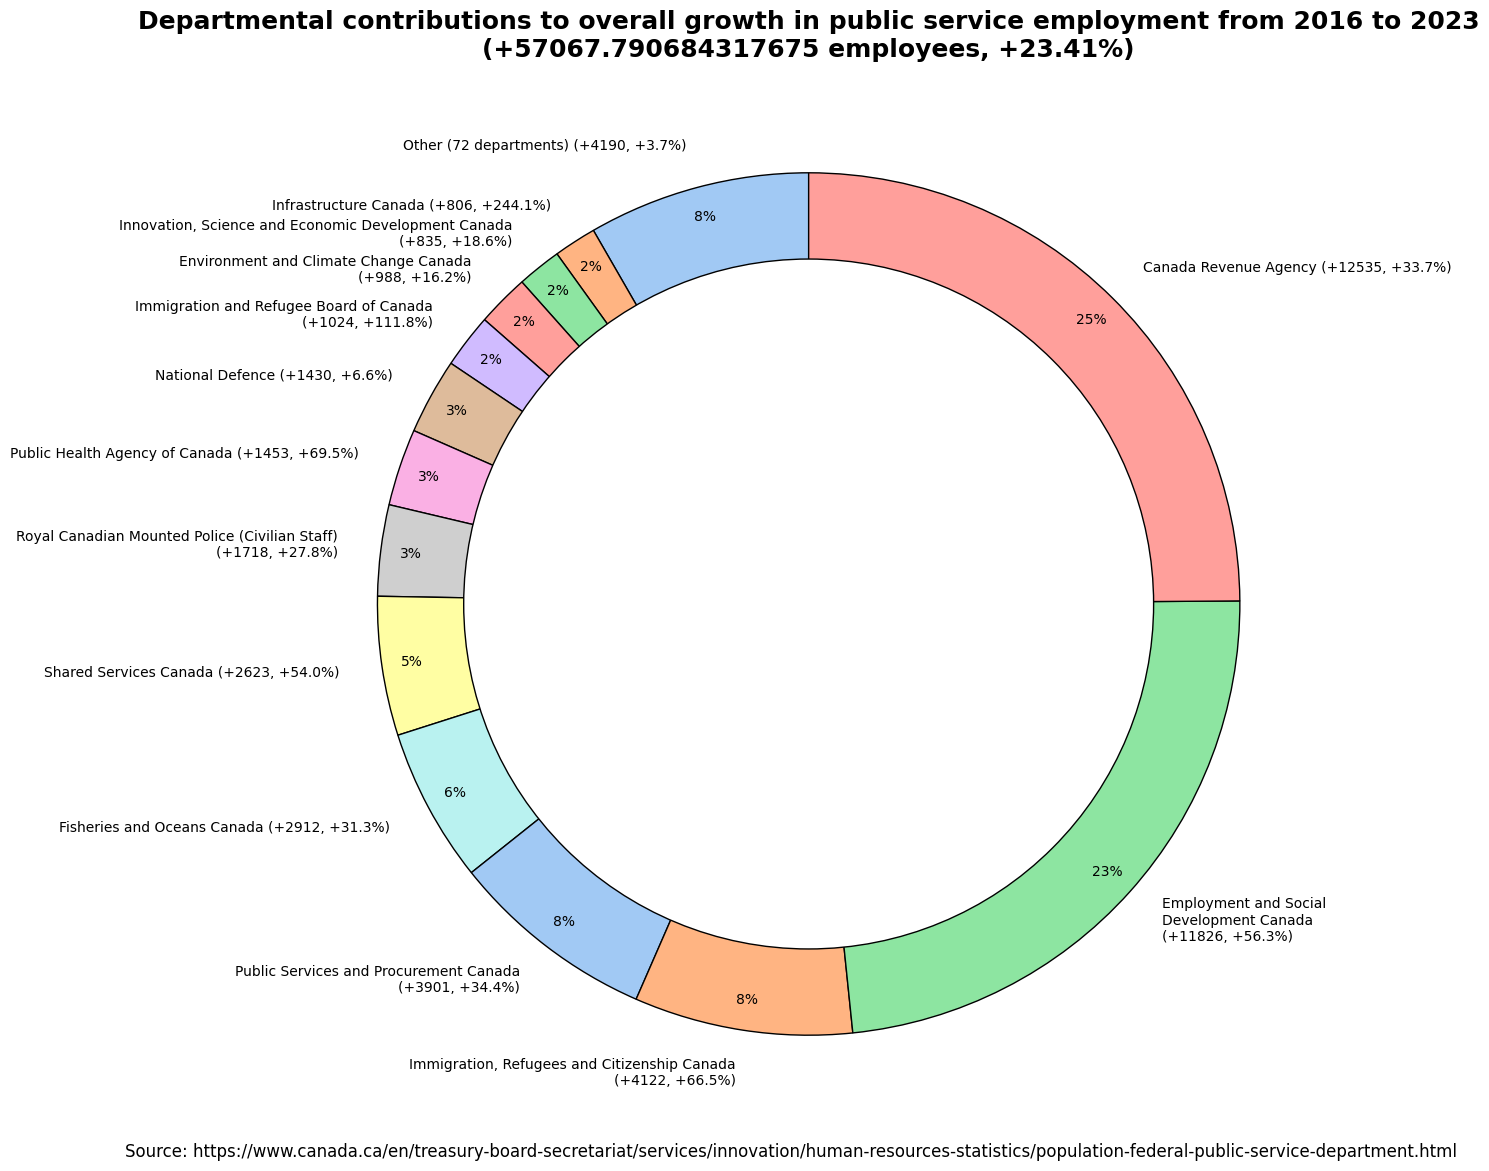

In [12]:
df = dfs["dept_pop_norm"]
df = df.drop(columns=["Universe"])

# What is the absolute difference between 2023 values and 2016 values, for each department?
df_2023 = df[df["Year"] == 2023]
df_2016 = df[df["Year"] == 2016]
df_2016 = df_2016.drop(columns=["Year"])
df_2016 = df_2016.set_index("Departments and Agencies")
df_2023 = df_2023.drop(columns=["Year"])
df_2023 = df_2023.set_index("Departments and Agencies")

# Find the difference between 2023 and 2016
total_diff = df_2023["Employees"].sum() - df_2016["Employees"].sum()
percent_diff = 100 * df_2023["Employees"].sum() / df_2016["Employees"].sum() - 100

df_diff = df_2023 - df_2016
df_diff = df_diff.reset_index()
df_diff = df_diff.sort_values(by=["Employees"], ascending=False)
# Pie chart of all departments by Diff
df_diff = df_diff.sort_values(by=["Employees"], ascending=True)
# Group the smallest growth departments together
# How many small departments?
min_size = 800
num_small = df_diff[df_diff["Employees"] < min_size].shape[0]
other_name = f"Other ({num_small} departments)"
df_diff.loc[df_diff["Employees"] < min_size, "Departments and Agencies"] = other_name
df_diff = df_diff.groupby(["Departments and Agencies"]).sum().reset_index()
df_diff = df_diff.sort_values(by=["Employees"], ascending=True)
# Put the "other" category last
df_diff2 = df_diff[df_diff["Departments and Agencies"] != other_name]
df_diff2 = pd.concat(
    [
        df_diff[df_diff["Departments and Agencies"] == other_name],
        df_diff2,
    ]
)
# Drop rows with 0 employees
df_diff2 = df_diff2[df_diff2["Employees"] != 0]
# Find the % increase for each of the departments in df_diff2
# First, combine the departments NOT in df_diff2 into the other_name category
df_2016 = df_2016.reset_index()
df_2016.loc[~(df_2016["Departments and Agencies"].isin(df_diff2["Departments and Agencies"])), "Departments and Agencies"] = other_name
df_2016 = df_2016.groupby(["Departments and Agencies"]).sum().reset_index()
df_diff2 = df_diff2.merge(
    df_2016, on="Departments and Agencies", how="left", suffixes=("", "_2016")
)
df_diff2["% increase"] = (
    100 * df_diff2["Employees"] / df_diff2["Employees_2016"]
)
# Replace zero with infinity symbol
df_diff2["% increase"] = df_diff2["% increase"].replace(np.inf, "∞")
# Round to 1 decimal place
df_diff2["% increase"] = df_diff2["% increase"].round(1)

df_diff2["Departments and Agencies"] = df_diff2["Departments and Agencies"].replace(
    "Employment and Social Development Canada",
    "Employment and Social\nDevelopment Canada",
)
# Add the absolute number and % to the end of the "Departments and Agencies" column in parens
df_diff2["Departments and Agencies"] = (
    df_diff2["Departments and Agencies"]
    + " (+"
    + df_diff2["Employees"].astype(int).astype(str)
    + ", +"
    + df_diff2["% increase"].astype(str)
    + "%)"
)
# If the line is too long (X chars), add a line break before the parentheses
# Or if its one the following:
line_break_depts = [
    "Innovation, Science and Economic Development Canada",
    "Environment and Climate Change Canada",
]
df_diff2["Departments and Agencies"] = df_diff2["Departments and Agencies"].apply(
    lambda x: x.replace(" (+", "\n(+") if len(x) > 53 or x.split("(")[0].strip() in line_break_depts else x
)

df_diff2.plot.pie(
    y="Employees",
    labels=df_diff2["Departments and Agencies"],
    figsize=(14, 14),
    autopct="%1.0f%%",
    startangle=90,
    legend=False,
    # Light pastel colors for text contrast
    colors=sns.color_palette("pastel"),
    # The slices should have a black outline
    wedgeprops={"linewidth": 1, "edgecolor": "black"},
    # Only show the percent labels if the slice is large enough
    pctdistance=0.93,
)
# Don't show the y-axis label
plt.ylabel("")
# Left-align the title
plt.title(
    (
        "Departmental contributions to overall growth in public service employment from 2016 to 2023\n"
        f"(+{total_diff} employees, +{percent_diff:.2f}%)"
    ),
    fontsize=18,
    fontdict=(
        # Bold the title
        {"fontweight": "bold"}
    ),
)
# Take out the middle of the pie chart to make it a donut
centre_circle = plt.Circle((0, 0), 0.8, fc="white")
# The circle needs a border like the slices, black and 1px wide
centre_circle.set_edgecolor("black")
centre_circle.set_linewidth(1)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Add source text to the bottom
plt.figtext(
    0.5,
    0.1,
    "Source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html",
    ha="center",
    fontsize=12,
)

# Finally, add an inset graph in the centre of the donut
# a = plt.axes([.4, .4, .25, .25], facecolor='y')


In [13]:
# stacked area chart of the top 10 departments by employees per year
# group all but the top 10 departments into "other"
# then plot the top 10 + other with plotly

df = dfs["dept_pop_norm"]
df = df.drop(columns=["Universe"])

# top 10 departments by employees overall
top_depts = df.groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(30).index.tolist()

all_depts = df["Departments and Agencies"].unique().tolist()
num_other_depts = len(all_depts) - len(top_depts)
# group all but the top 10 departments into "other"
other_str = f"Other ({num_other_depts} smallest departments)"
df["Departments and Agencies"] = df["Departments and Agencies"].apply(lambda x: x if x in top_depts else other_str)

# group by year and department
df = df.groupby(['Year', 'Departments and Agencies']).sum().reset_index()

# pivot to wide format
df = df.pivot(index='Year', columns='Departments and Agencies', values='Employees').reset_index()

# plot with plotly
import plotly.express as px

fig = px.area(df, x="Year", y=[other_str] + top_depts, title='Public service employment by department, 2010 to 2023')

# Add a vertical line for Trudeau's election (2015)
fig.add_vline(x=2015, line_width=2, line_dash="dash", line_color="blue")
# Add a vertical line for the pandemic (2020)
fig.add_vline(x=2020, line_width=2, line_dash="dash", line_color="red")
# Label the lines
fig.add_annotation(x=2015, y=0, text="Trudeau elected", showarrow=True, arrowhead=1)
fig.add_annotation(x=2020, y=0, text="Pandemic", showarrow=True, arrowhead=1)

# Add source text to the bottom
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0,
    y=-0.12,
    text="Source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html",
    showarrow=False,
)

# Change legend title
fig.update_layout(legend_title_text='Departments (bottom to top on the graph)')
# y-axis label
fig.update_yaxes(title_text='Total number of employees')

# Change height to make it more square
fig.update_layout(height=800)
fig.show()

In [14]:
# Same thing but with the top 10 departments by growth in absolute numbers
df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()


# group all but the top 10 departments into "other"
df["Departments and Agencies"] = df["Departments and Agencies"].apply(lambda x: x if x in top_depts else "Other")

# group by year and department
df = df.groupby(['Year', 'Departments and Agencies']).sum().reset_index()

# pivot to wide format
df = df.pivot(index='Year', columns='Departments and Agencies', values='Employees').reset_index()

# plot with plotly
import plotly.express as px

fig = px.area(df, x="Year", y=["Other"] + top_depts, title='Public service employment over time')

# Add a vertical line for Trudeau's election (2015)
fig.add_vline(x=2015, line_width=2, line_dash="dash", line_color="blue")
# Add a vertical line for the pandemic (2020)
fig.add_vline(x=2020, line_width=2, line_dash="dash", line_color="red")
# Label the lines
fig.add_annotation(x=2015, y=0, text="Trudeau elected", showarrow=True, arrowhead=1)
fig.add_annotation(x=2020, y=0, text="Pandemic", showarrow=True, arrowhead=1)
fig.show()

In [15]:
# Same thing but with the top 10 departments by growth in absolute numbers
df = dfs["dept_pop_norm"]
df = df.drop(columns=['Universe'])

df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(10).index.tolist()

df = df_scaled
# group all but the top 10 departments into "other"
df["Departments and Agencies"] = df["Departments and Agencies"].apply(lambda x: x if x in top_depts else "Other")

# group by year and department
df = df.groupby(['Year', 'Departments and Agencies']).sum().reset_index()

# pivot to wide format
df = df.pivot(index='Year', columns='Departments and Agencies', values='Employees').reset_index()

# plot with plotly
import plotly.express as px

fig = px.area(df, x="Year", y=["Other"] + top_depts, title='Change in public service employment over time')

# Add a vertical line for Trudeau's election (2015)
fig.add_vline(x=2015, line_width=2, line_dash="dash", line_color="blue")
# Add a vertical line for the pandemic (2020)
fig.add_vline(x=2020, line_width=2, line_dash="dash", line_color="red")
# Label the lines
fig.add_annotation(x=2015, y=0, text="Trudeau elected", showarrow=True, arrowhead=1)
fig.add_annotation(x=2020, y=0, text="Pandemic", showarrow=True, arrowhead=1)
fig.show()

In [16]:
# stacked area chart of the top 10 departments by employees per year
# group all but the top 10 departments into "other"
# then plot the top 10 + other with plotly

df = dfs["dept_pop_norm"]
df = df.drop(columns=["Universe"])


df_scaled = df.copy()
emp_2010 = df[df['Year'] == 2010]
emp_2010 = emp_2010.drop(columns=['Year']).set_index('Departments and Agencies')
df_scaled = df_scaled.merge(emp_2010, on='Departments and Agencies', how='left', suffixes=('', '_2010'))
df_scaled["Employees"] = df_scaled["Employees"] - df_scaled["Employees_2010"]

df_scaled = df_scaled.drop(columns=['Employees_2010'])

max_y = df_scaled["Employees"].max()
min_y = df_scaled["Employees"].min()

top_depts = df_scaled.query("Year == 2023").groupby(['Departments and Agencies']).sum().sort_values(by=['Employees'], ascending=False).head(15).index.tolist()


all_depts = df["Departments and Agencies"].unique().tolist()
num_other_depts = len(all_depts) - len(top_depts)
# group all but the top 10 departments into "other"
other_str = f"Other ({num_other_depts} departments)"
df["Departments and Agencies"] = df["Departments and Agencies"].apply(lambda x: x if x in top_depts else other_str)

# group by year and department
df = df.groupby(['Year', 'Departments and Agencies']).sum().reset_index()

# pivot to wide format
df = df.pivot(index='Year', columns='Departments and Agencies', values='Employees').reset_index()

# plot with plotly
import plotly.express as px

fig = px.area(df, x="Year", y=[other_str] + top_depts, title='Public service employment by department, 2010 to 2023')

# Add a vertical line for Trudeau's election (2015)
fig.add_vline(x=2015, line_width=2, line_dash="dash", line_color="blue")
# Add a vertical line for the pandemic (2020)
fig.add_vline(x=2020, line_width=2, line_dash="dash", line_color="red")
# Label the lines
fig.add_annotation(x=2015, y=0, text="Trudeau elected", showarrow=True, arrowhead=1)
fig.add_annotation(x=2020, y=0, text="Pandemic", showarrow=True, arrowhead=1)

# Add source text to the bottom
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0,
    y=-0.12,
    text="Source: https://www.canada.ca/en/treasury-board-secretariat/services/innovation/human-resources-statistics/population-federal-public-service-department.html",
    showarrow=False,
)

# Change legend title
fig.update_layout(legend_title_text='Departments')
# y-axis label
fig.update_yaxes(title_text='Total number of employees')
fig.update_xaxes(title_text='')

# Change height to make it more square
fig.update_layout(height=600)
fig.show()